In [1]:
import os
import os.path as path
import sys

wk_dir = os.path.dirname(os.path.realpath('__file__'))
parent_code_dir =  path.abspath(path.join(wk_dir ,"../.."))
sys.path.append(parent_code_dir)

import logging
import random
import cv2
import math
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw


from MaskRCNN.building_blocks import utils
from MaskRCNN.config import config
from MaskRCNN.shapes import ShapesConfig, Dataset

%matplotllib inline

## Get/Prepare Data:
------

In [2]:
# Debugg
from MaskRCNN.building_blocks.data_processor import PreprareTrainData
conf = ShapesConfig()

batch_size = 1
# Get data from for randomly generated shapes
data = Dataset(num_images=batch_size, height=128, width=128, num_classes=4)
print ('Batch Meta: ', data.image_meta)
image_ids = data.image_meta.keys()

obj_ptd = PreprareTrainData(conf, data)
data_dict = obj_ptd.get_data(image_ids)
print(data_dict.keys())


##### GET DATA TO VIZUALIZE
run_for_batch_num = 0
# Get Batch Image
batch_images = data_dict['batch_images']

# Get ground truth boxes
batch_gt_bboxes = data_dict['batch_gt_bboxes']

# Get ground truth boxes
batch_gt_masks = data_dict['batch_gt_masks']

# Get Batch RPN Target Class
batch_rpn_target_class = data_dict['batch_rpn_target_class']

# Get Boxes with iou > 0.7 to gt_boxes: batch_rpn target box
batch_rpn_target_bbox = data_dict['batch_rpn_target_bbox']

# Get Positive anchors with IOU more than 0.7
batch_positive_anchors = data_dict['batch_positive_anchors']

Batch Meta:  {0: {'width': 128, 'bg_color': array([150, 122, 110]), 'height': 128, 'object_info': [('triangle', (156, 2, 101), (40, 84, 24)), ('square', (86, 212, 158), (29, 36, 21)), ('square', (98, 106, 30), (92, 58, 31))]}}
Anchors Max Min length:  154.509667992 -90.5096679919
Anchor shape:  (4092, 4)
Achor Area:  (4092,)
active_class_ids  [0 1 1 0]
pos_idx,  3
neg_idx,  4053 128
+ve class count  3
-ve class count  128
neutral class count  3961
batch_images  (1, 128, 128, 3)
batch_gt_masks  (1, 128, 128, 100)
batch_gt_class_ids  (1, 100)
batch_gt_bboxes  (1, 100, 4)
batch_image_metas  (1, 16)
batch_rpn_target_class  (1, 4092, 1)
batch_rpn_target_bbox  (1, 256, 4)
batch_positive_anchors  (1, 3, 4)
dict_keys(['batch_gt_masks', 'batch_gt_class_ids', 'batch_gt_bboxes', 'batch_image_metas', 'batch_rpn_target_class', 'batch_images', 'batch_rpn_target_bbox', 'batch_positive_anchors'])


In [3]:
# batch_gt_bboxes.shape
indice = np.where(np.sum(abs(batch_gt_bboxes), axis=2)[run_for_batch_num] != 0)[0]
print(indice)
image = batch_images[run_for_batch_num]
gt_box = batch_gt_bboxes[run_for_batch_num, indice]
gt_masks = batch_gt_masks[run_for_batch_num, :,:,indice]
anchors_idx_with_neg_iou = np.where(batch_rpn_target_class[run_for_batch_num] == -1)[0]
anchors_idx_with_neutral_iou = np.where(batch_rpn_target_class[run_for_batch_num] == 0)[0]
anchors_idx_with_pos_iou = np.where(batch_rpn_target_class[run_for_batch_num] == 1)[0]
rpn_target_bbox = batch_rpn_target_bbox[run_for_batch_num, indice]
positive_anchor_bbox = batch_positive_anchors[run_for_batch_num]

positive_anchors = obj_ptd.anchors[anchors_idx_with_pos_iou]
neutral_anchors = obj_ptd.anchors[anchors_idx_with_neutral_iou]
negative_anchors = obj_ptd.anchors[anchors_idx_with_neg_iou]

print ('image ', image.shape)
print ('gt_box ', gt_box.shape)
print ('gt_masks ', gt_masks.shape)
print ('rpn_target_bbox ', rpn_target_bbox.shape)

print ('anchors_idx_with_neg_iou ', len(anchors_idx_with_neg_iou))
print ('anchors_idx_with_neutral_iou ', len(anchors_idx_with_neutral_iou))
print ('anchors_idx_with_pos_iou ', len(anchors_idx_with_pos_iou))
print ('positive_anchors ', positive_anchors.shape)
print ('neutral_anchors ', neutral_anchors.shape)
print ('negative_anchors ', negative_anchors.shape)


print ('positive_anchor_bbox ', positive_anchor_bbox.shape)



[0 1 2]
image  (128, 128, 3)
gt_box  (3, 4)
gt_masks  (3, 128, 128)
rpn_target_bbox  (3, 4)
anchors_idx_with_neg_iou  128
anchors_idx_with_neutral_iou  3961
anchors_idx_with_pos_iou  3
positive_anchors  (3, 4)
neutral_anchors  (3961, 4)
negative_anchors  (128, 4)
positive_anchor_bbox  (3, 4)


In [4]:
neutral_anchors

array([[  -5.65685425,   -2.82842712,    5.65685425,    2.82842712],
       [  -4.        ,   -4.        ,    4.        ,    4.        ],
       [  -2.82842712,   -5.65685425,    2.82842712,    5.65685425],
       ..., 
       [ -26.50966799,   18.745166  ,  154.50966799,  109.254834  ],
       [   0.        ,    0.        ,  128.        ,  128.        ],
       [  18.745166  ,  -26.50966799,  109.254834  ,  154.50966799]])

#### Check if Positive index on the anchor box is the same as extracted positive_anchor_box

In [5]:
print (obj_ptd.anchors[anchors_idx_with_pos_iou])  
print (positive_anchor_bbox)

[[  16.   16.   48.   48.]
 [   0.   64.   64.  128.]
 [  64.   32.  128.   96.]]
[[  16.   16.   48.   48.]
 [   0.   64.   64.  128.]
 [  64.   32.  128.   96.]]


## Vizualize obejcts:
---------

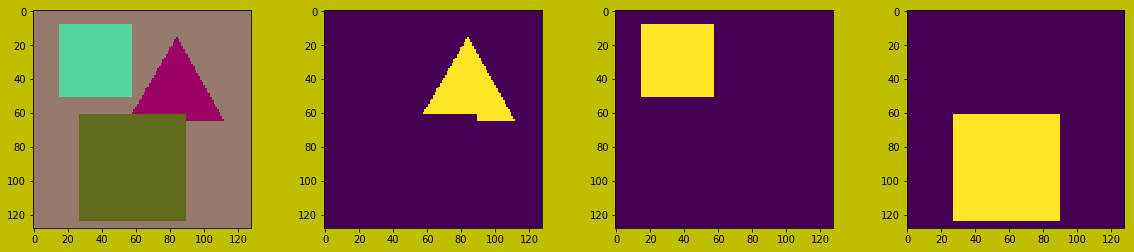

In [6]:
from MaskRCNN.visualize import Visualize
obj_viz = Visualize(rows=1, cols=4, figsize=(20,4))

obj_viz.vizualize_image(image)
for j in range(0,3):  # total number of labels
    if j < gt_masks.shape[0]:
        obj_viz.vizualize_image(gt_masks[j,:,:])
    else:
        obj_viz.num += 1
obj_viz.show()

## Vizualize Ground Truth Boxes
---------

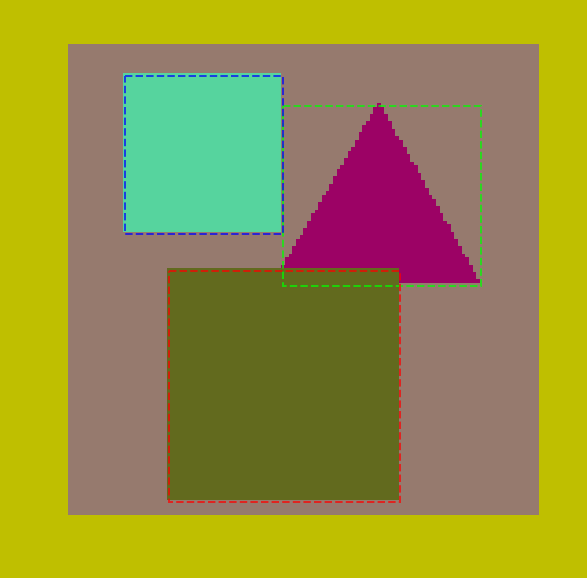

In [7]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(gt_box, image)
obj_viz.show()

## Vizualize Positive Anchors woth IOU > 0.7 or the bouding box with max IOU
------

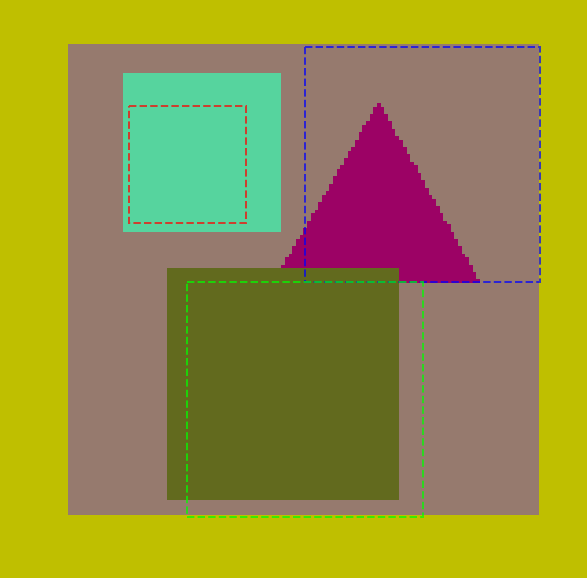

In [8]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(positive_anchor_bbox, image)
obj_viz.show()

## Vizualize Negative Anchors with IOU < 0.3
----------

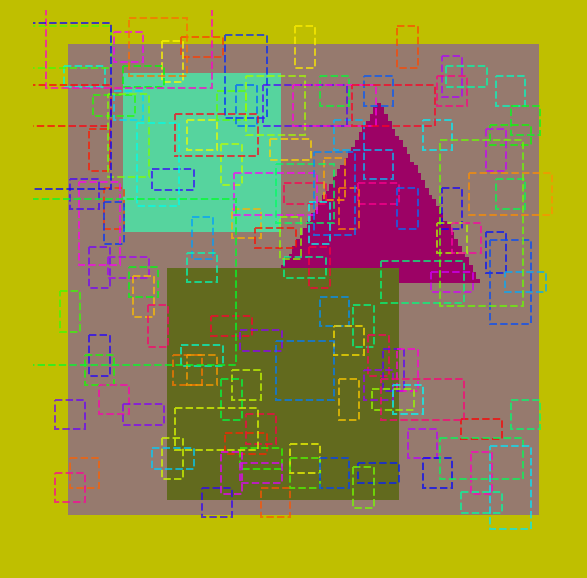

In [9]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(negative_anchors, image)
obj_viz.show()

## Vizualize Neutral Anchors 0.3<IOU<0.7

#### Read this:
* You might be wondering, why many boxes, which seem to have iou = 0 are marked as neutral. This is becasue. In normal scenario we would have a class imbalance problem, where we would end up having more negative classes than positive classes.

* Moreover, for regression Loss we have stated a limit of 256 anchors 128(+ve) and 128(-ve). in real scenario we would have -ve anchors >>> 128. Hence for training and loss calculation we select only 128 anchors from the list of all -ve anchors and make all other -ve anchors as neutral.

In [10]:
np.random.shuffle(neutral_anchors)

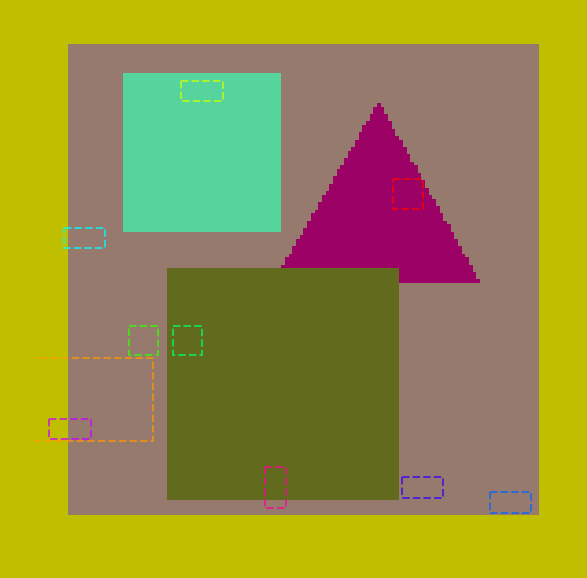

In [11]:
obj_viz = Visualize(rows=1, cols=1, figsize=(20,10))
obj_viz.visualize_boxes(neutral_anchors[0:10], image)
obj_viz.show()

## Lets do some Training:
--------

In [12]:
from MaskRCNN.training import Train as Train
from MaskRCNN.training_debug import Train as TrainDebug
print(data_dict['batch_image_metas'])
pretrained_weights_path = '/Users/sam/All-Program/App-DataSet/ObjectDetection/MaskRCNN/mask_rcnn_coco.h5'

obj_trn = Train(conf, batch_size=batch_size,
                pretrained_weights_path=None)
obj_trn.exec_sess(data_dict, image_ids)


Using TensorFlow backend.


[[  0 128 128   3 128 128   3   0   0 128 128   1   0   1   1   0]]
(process_images) Image Resized Nnormalized: (shape)  (1, 128, 128, 3)
(process_images) Image meta: (shape)  (1, 16)
(process_images) Image Window: (shape)  (1, 4)
(process_images) Anchors: (shape)  (1, 4092, 4)
(1, 128, 128, 3) (1, 16) (1, 4) (1, 4092, 4)
(FPN) C2: (shape)  (?, 32, 32, 256)
(FPN) C3: (shape)  (?, 16, 16, 512)
(FPN) C4: (shape)  (?, 8, 8, 1024)
(FPN) C5: (shape)  (?, 4, 4, 2048)
(FPN) P2: (shape)  (?, 32, 32, 256)
(FPN) P3: (shape)  (?, 16, 16, 256)
(FPN) P4: (shape)  (?, 8, 8, 256)
(FPN) P5: (shape)  (?, 4, 4, 256)
(FPN) P6: (shape)  (?, 2, 2, 256)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) Class Probs (shape)  (?, ?, 2)
(RPN) Bbox (shape)  (?, ?, 4)
(RPN) Class Logits (shape)  (?, ?, 2)
(RPN) C

In [13]:
obj_trn.outputs_[4]    # mrcnn_target_class_ids

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [14]:
positive_anchor_bbox

array([[  16.,   16.,   48.,   48.],
       [   0.,   64.,   64.,  128.],
       [  64.,   32.,  128.,   96.]])

In [15]:
anchors_idx_with_pos_iou

array([3895, 4054, 4075])

In [16]:
obj_trn.outputs_[2][0][anchors_idx_with_pos_iou,:]

array([[ -1.10795814e+25,  -1.81031993e+26,   1.01403191e+26,
         -2.39718114e+26],
       [ -1.13450243e+26,  -1.51483325e+26,   1.72908342e+26,
         -8.07715039e+25],
       [  1.10252518e+26,  -2.49892711e+26,   2.45126976e+26,
         -4.40479010e+25]], dtype=float32)

## Debug Detection Target creation layer:

In [13]:
from MaskRCNN.building_blocks import data_processor
def get_detection_target_graph(proposals_, input_gt_class_ids, input_gt_bboxes):
    batch_rois = []
    batch_rois_gt_class_ids = []
    batch_rois_gt_class_boxes = []
    for i in range(0, obj_trn.batch_size):
        obj_dp = data_processor.BuildDetectionTargets(
                conf, proposals_[i], input_gt_class_ids[i], input_gt_bboxes[i],
                DEBUG=True)
        rois, roi_gt_class_ids, roi_gt_box_deltas = obj_dp.get_target_rois()
        debug_opt = obj_dp.debug_outputs()
        break
#         batch_rois.append(rois)
#         batch_rois_gt_class_ids.append(roi_gt_class_ids)
#         batch_rois_gt_class_boxes.append(roi_gt_box_deltas)

#         batch_rois = tf.stack(batch_rois, axis=0)
#         batch_rois_gt_class_ids = tf.concat(batch_rois_gt_class_ids, axis=0)
#         batch_rois_gt_class_boxes = tf.stack(batch_rois_gt_class_boxes, axis=0)

    return batch_rois, batch_rois_gt_class_ids, batch_rois_gt_class_boxes, debug_opt

In [14]:
rois, mrcnn_target_class_ids, mrcnn_target_box, debug_opt = get_detection_target_graph(
            obj_trn.proposals,
            obj_trn.input_gt_class_ids,
            obj_trn.input_gt_bboxes
)

In [25]:
debug_outputs = [debug_opt['non_zeros'],
                    debug_opt['gt_boxes_non_zero'],
                    debug_opt['gt_class_ids_non_zero'],
                    debug_opt['iou'],
                    debug_opt['roi_iou_max'],
                    debug_opt['pos_indices_05more'],
                    debug_opt['neg_indices_05more'],
                    debug_opt['num_pos_inst'],
                    debug_opt['pos_indices'],
                    debug_opt['pos_count'],
                    debug_opt['neg_cnt'],
                    debug_opt['neg_indices'],
                    debug_opt['pos_rois'],
                    debug_opt['neg_rois'],
                    debug_opt['pos_iou'],
                    debug_opt['roi_gt_box_assignment'],
                    debug_opt['roi_gt_class_ids'],
                    debug_opt['roi_gt_boxes'],
                    debug_opt['roi_gt_box_deltas']
                ]

feed_dict = {obj_trn.xIN: obj_trn.batch_images,
         obj_trn.anchors: obj_trn.anchors_,
         obj_trn.input_gt_class_ids: obj_trn.batch_gt_class_ids,
         obj_trn.input_gt_bboxes: obj_trn.batch_gt_bboxes,
         obj_trn.rpn_target_class: obj_trn.batch_rpn_target_class,
         obj_trn.rpn_target_bbox: obj_trn.batch_rpn_target_bbox
         }

import tensorflow as tf
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_ = sess.run(debug_outputs, feed_dict=feed_dict)
    

TypeError: Fetch argument 10 has invalid type <class 'int'>, must be a string or Tensor. (Can not convert a int into a Tensor or Operation.)

In [16]:
debug_opt

{'gt_boxes_non_zero': <tf.Tensor 'gt_box_non_zeros_1/Gather:0' shape=(?, 4) dtype=float32>,
 'gt_class_ids_non_zero': <tf.Tensor 'gt_class_id_non_zeros_1/Gather:0' shape=(?,) dtype=int32>,
 'iou': <tf.Tensor 'Reshape_21:0' shape=(?, ?) dtype=float32>,
 'neg_cnt': <tf.Tensor 'sub_34:0' shape=() dtype=int32>,
 'neg_indices': <tf.Tensor 'strided_slice_84:0' shape=(?,) dtype=int64>,
 'neg_indices_05more': <tf.Tensor 'strided_slice_84:0' shape=(?,) dtype=int64>,
 'neg_rois': <tf.Tensor 'Gather_12:0' shape=(?, ?) dtype=float32>,
 'non_zeros': <tf.Tensor 'Cast_30:0' shape=(100,) dtype=bool>,
 'num_pos_inst': 10,
 'pos_count': <tf.Tensor 'strided_slice_83:0' shape=() dtype=int32>,
 'pos_indices': <tf.Tensor 'strided_slice_82:0' shape=(?,) dtype=int64>,
 'pos_indices_05more': <tf.Tensor 'strided_slice_82:0' shape=(?,) dtype=int64>,
 'pos_iou': <tf.Tensor 'Gather_13:0' shape=(?, ?) dtype=float32>,
 'pos_rois': <tf.Tensor 'Gather_11:0' shape=(?, ?) dtype=float32>,
 'roi_gt_box_assignment': <tf.Te